In [20]:
import numpy as np
from scipy.io import loadmat
from sklearn.utils import resample

# Load and preprocess data
dataset = loadmat('mnist_10digits.mat')
X_full_train = dataset['xtrain'] / 255.0  # Normalize to [0, 1]
Y_full_train = dataset['ytrain'].ravel()
X_eval = dataset['xtest'] / 255.0  # Full test set of 10,000 samples
Y_eval = dataset['ytest'].ravel()

# Downsample the training set for specific models to 5,000 samples
X_reduced_train, Y_reduced_train = resample(X_full_train, Y_full_train, n_samples=5000, random_state=42)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Tune KNN to find optimal n_neighbors
neighbor_range = list(range(1, 30))
params = {'n_neighbors': neighbor_range}
knn_base = KNeighborsClassifier()
knn_search = GridSearchCV(knn_base, params, cv=10)
optimal_knn = knn_search.fit(X_reduced_train, Y_reduced_train)
optimal_k = optimal_knn.best_estimator_.get_params()['n_neighbors']
print('Optimal n_neighbors for KNN:', optimal_k)

# Define classifiers with tuned parameters
model_names = ['KNN, k=' + str(optimal_k), 'Logistic Regression', 'SVM', 'Kernel SVM', 'Neural Networks']
model_list = [
    KNeighborsClassifier(n_neighbors=optimal_k),
    LogisticRegression(solver='newton-cg', max_iter=1000),
    SVC(kernel="linear"),
    SVC(kernel='rbf'),
    MLPClassifier(hidden_layer_sizes=(20, 10), alpha=1, max_iter=1000)
]

# Training and evaluation loop
for idx in range(len(model_names)):
    current_name = model_names[idx]
    current_model = model_list[idx]
    
    print("\nCurrent Model:", current_name)
    
    # Select dataset for model training based on type
    if current_name.startswith('KNN') or current_name == 'SVM' or current_name == 'Kernel SVM':
        current_model.fit(X_reduced_train, Y_reduced_train)
    else:
        current_model.fit(X_full_train, Y_full_train)
        
    # Predictions on train and test data
    train_predictions = current_model.predict(X_full_train)
    test_predictions = current_model.predict(X_eval)
    
    # Compute and display accuracy
    train_accuracy = accuracy_score(Y_full_train, train_predictions)
    test_accuracy = accuracy_score(Y_eval, test_predictions)
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Display classification report and confusion matrix
    print("Classification Report:\n", classification_report(Y_eval, test_predictions))
    print("Confusion Matrix:\n", confusion_matrix(Y_eval, test_predictions))


Q4.1 - Calculating Prize and Hello chance of Spam

In [13]:
### Caluclating Prize chance of spam:

import math

# Define variables 
N_total = 150 + 1000 + 10 + 15000  # Total count
N_11 = 150   # N11
N_10 = 1000  # N10
N_01 = 10    # N01
N_00 = 15000 # N00
N1_total = 150 + 1000   # N1_
N_1_total = 150 + 10    # N_1
N0_total = 10 + 15000   # N0_
N_total_0 = 1000 + 15000 # N_0

# Calculate mutual information for "prize" and "spam"
I_prize_spam = (N_11/N_total) * math.log((N_total * N_11) / (N1_total * N_1_total), 2) \
               + (N_01/N_total) * math.log((N_total * N_01) / (N0_total * N_1_total), 2) \
               + (N_10/N_total) * math.log((N_total * N_10) / (N1_total * N_total_0), 2) \
               + (N_00/N_total) * math.log((N_total * N_00) / (N0_total * N_total_0), 2)

# Print the result
print(I_prize_spam)


0.03296011876395397


In [15]:
import math

# Define variables for "hello" and "spam"
N_total_hello = 145 + 15 + 11000 + 5000  # Total count
N_11_hello = 145   # N11
N_10_hello = 15    # N10
N_01_hello = 11000 # N01
N_00_hello = 5000  # N00
N1_total_hello = 145 + 15      # N1_
N_1_total_hello = 145 + 11000  # N_1
N0_total_hello = 11000 + 5000  # N0_
N_total_0_hello = 15 + 5000    # N_0

# Calculate mutual information for "hello" and "spam"
I_hello_spam = (N_11_hello / N_total_hello) * math.log((N_total_hello * N_11_hello) / (N1_total_hello * N_1_total_hello), 2) \
               + (N_10_hello / N_total_hello) * math.log((N_total_hello * N_10_hello) / (N1_total_hello * N_total_0_hello), 2) \
               + (N_01_hello / N_total_hello) * math.log((N_total_hello * N_01_hello) / (N0_total_hello * N_1_total_hello), 2) \
               + (N_00_hello / N_total_hello) * math.log((N_total_hello * N_00_hello) / (N0_total_hello * N_total_0_hello), 2)

# Print the result
print(I_hello_spam)


0.0019480406287359314


Q4 Part B - Calculate the CUSUM Statistic 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

# Set seed for reproducibility
np.random.seed(4624)

# Generate samples for f0 and f1 distributions
f_0_samples = np.random.normal(0, 1, 100)   # 100 samples from N(0, 1)
f_1_samples = np.random.normal(0, np.sqrt(1.5), 50)  # 50 samples from N(0, 1.5)

# Combine samples into one sequence
samples = np.concatenate((f_0_samples, f_1_samples))

# Plot the samples
plt.figure(figsize=(10, 5))
plt.plot(samples, label="Samples")
plt.title("IID Samples from f0 and f1")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig('cusum_samples_modified.jpg')
plt.show()

# Define the CUSUM function for W_t calculation
def cusum_stat(x):
    f0_pdf = norm(0, 1).pdf(x)             # PDF of N(0, 1)
    f1_pdf = norm(0, np.sqrt(1.5)).pdf(x)  # PDF of N(0, 1.5)
    return np.log(f1_pdf / f0_pdf)         # Log-likelihood ratio

# Calculate the CUSUM statistic
W = [0]  # Start CUSUM statistic with W_0 = 0
for i in range(len(samples)):
    W_prev = W[-1]
    W_current = max(W_prev + cusum_stat(samples[i]), 0)
    W.append(W_current)

# Plot the CUSUM statistic
plt.figure(figsize=(10, 5))
plt.plot(W, label="CUSUM Statistic", color="orange")
plt.axvline(x=100, color='red', linestyle='--', label="Change Point at 100")
plt.title("CUSUM Statistic for Change Detection")
plt.xlabel("Sample Index")
plt.ylabel("CUSUM Value")
plt.legend()
plt.grid(True)
plt.savefig('cusum_statistic_modified.jpg')
plt.show()


5 - Imaging/MRI 

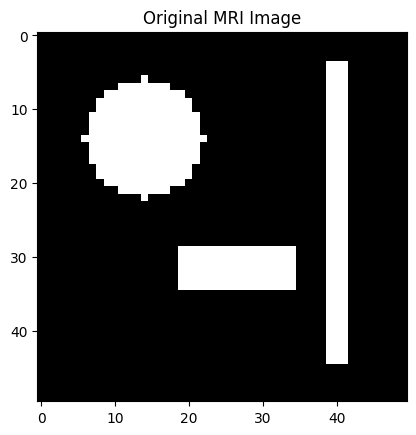

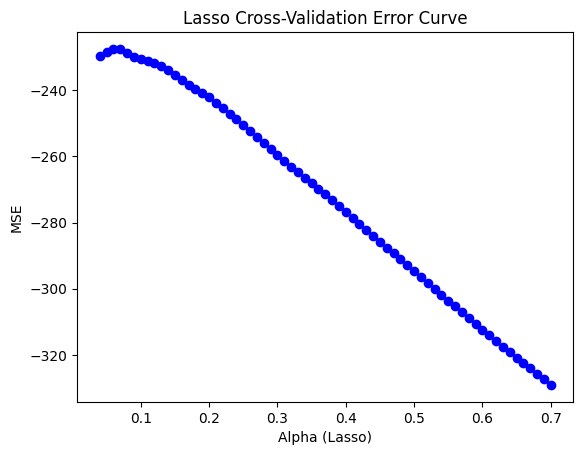

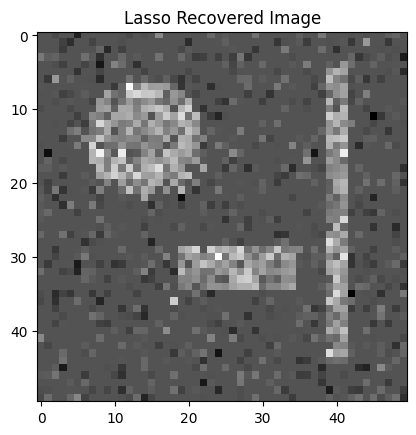

Lasso Regression Grading Metrics
Best Alpha: 0.060000000000000005
Coefficients: [-0.         -0.         -0.11555682 ...  0.09759464  0.28965177
 -0.35108006]
MSE: 4.7626766251365495
R² Score: 0.9890574742344148


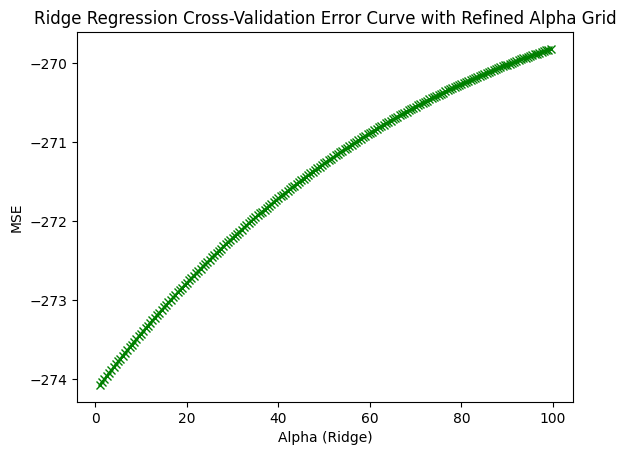

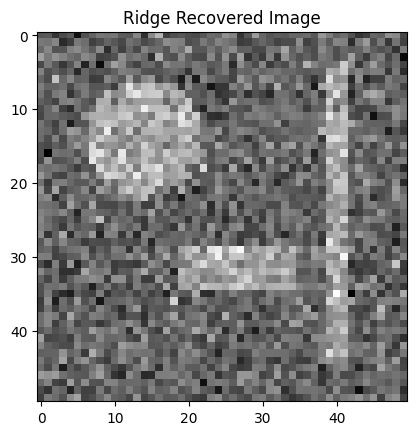

Ridge Regression Grading Metrics
Best Alpha: 99.5
Coefficients: [[-0.10237238 -0.07691321 -0.34939146 ...  0.20723809  0.30718927
  -0.22765375]]
MSE: 1.3998469570451038
R² Score: 0.9967837704297418


In [37]:
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Load data
data = spio.loadmat('cs.mat', squeeze_me=True)
mri = data['img']
x = mri.reshape((50 * 50))
plt.imshow(mri, cmap='gray')
plt.title('Original MRI Image')
plt.savefig('mri_original_img.jpg')
plt.show()

# Initialize variables for compressed sensing simulation
A = np.random.normal(0, 1, (1300, 2500))
eps = np.random.normal(0, np.sqrt(25), (1300, 1))
y = (A @ x).reshape((1300, 1)) + eps

# Lasso Regression with Cross-Validation
lasso_model = Lasso(tol=1e-8, max_iter=100000)
cv = KFold(n_splits=10, random_state=5, shuffle=True)
grid_lasso = {'alpha': np.arange(0.04, 0.71, 0.01)}

# Search for best alpha in Lasso
lasso_search = GridSearchCV(lasso_model, grid_lasso, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
lasso_results = lasso_search.fit(A, y)
best_alpha_lasso = lasso_results.best_params_['alpha']

# Cross-Validation Error Curve for Lasso
mse_lasso = lasso_results.cv_results_['mean_test_score']
plt.plot(grid_lasso['alpha'], mse_lasso, linestyle='--', marker='o', color='blue')
plt.xlabel('Alpha (Lasso)')
plt.ylabel('MSE')
plt.title('Lasso Cross-Validation Error Curve')
plt.savefig('mri_lasso_cv_curve.jpg')
plt.show()

# Fit Lasso with Best Alpha
lasso_final = Lasso(alpha=best_alpha_lasso)
lasso_final.fit(A, y)
lasso_img = lasso_final.coef_.reshape(50, 50)
plt.imshow(lasso_img, cmap='gray')
plt.title('Lasso Recovered Image')
plt.savefig('mri_lasso_img.jpg')
plt.show()

# Grading metrics for Lasso
lasso_mse = mean_squared_error(y, A @ lasso_final.coef_.reshape(-1, 1))
lasso_r2 = r2_score(y, A @ lasso_final.coef_.reshape(-1, 1))
print("Lasso Regression Grading Metrics")
print("Best Alpha:", best_alpha_lasso)
print("Coefficients:", lasso_final.coef_)
print("MSE:", lasso_mse)
print("R² Score:", lasso_r2)

# Ridge Regression with a refined Cross-Validation grid
ridge_model = Ridge()
grid_ridge = {'alpha': np.arange(1, 100, 0.5)}

# Search for best alpha in Ridge
ridge_search = GridSearchCV(ridge_model, grid_ridge, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
ridge_results = ridge_search.fit(A, y)
best_alpha_ridge = ridge_results.best_params_['alpha']

# Cross-Validation Error Curve for Ridge with finer grid
mse_ridge = ridge_results.cv_results_['mean_test_score']
plt.plot(grid_ridge['alpha'], mse_ridge, linestyle='-', marker='x', color='green')
plt.xlabel('Alpha (Ridge)')
plt.ylabel('MSE')
plt.title('Ridge Regression Cross-Validation Error Curve with Refined Alpha Grid')
plt.savefig('mri_ridge_cv_curve_refined.jpg')
plt.show()

# Fit Ridge with the best alpha found
ridge_final = Ridge(alpha=best_alpha_ridge)
ridge_final.fit(A, y)
ridge_img = ridge_final.coef_.reshape(50, 50)

# Display and save the Ridge-recovered image
plt.imshow(ridge_img, cmap='gray')
plt.title('Ridge Recovered Image')
plt.savefig('mri_ridge_img.jpg')
plt.show()

# Grading metrics for Ridge
ridge_mse = mean_squared_error(y, A @ ridge_final.coef_.reshape(-1, 1))
ridge_r2 = r2_score(y, A @ ridge_final.coef_.reshape(-1, 1))
print("Ridge Regression Grading Metrics")
print("Best Alpha:", best_alpha_ridge)
print("Coefficients:", ridge_final.coef_)
print("MSE:", ridge_mse)
print("R² Score:", ridge_r2)
